# **84 Lumber: 3-Year Delivery Analysis (2022-2025)**

## Background

**Preface**  
**84 Lumber** is a nationwide supply chain company that is responsible for using forklift trucks to deliver lumber. For the past three years, their Denton, TX location has been logging deliveries in a spreadsheet containing daily information on the trucks, deliveries, and reschedules. It goes from Jan. 3, 2022, to Mar. 17, 2025.

**Objective**  
Visualize the truck delivery data from Jan. 3, 2022 to Mar. 17, 2025.

**QUESTION**  
**What has been the trend of trucks and deliveries for the past three years?**

## Set up data for model fitting

After dataset joining with SQL and data preprocessing with Excel.

Note: Data with inconsistent reschedule weight and quantities (0 in one column but not in the other), missing precipitation data, and an outlier in `delivery_weight` (83913255 lbs. on 10/3/24) have previously been removed in Excel.

In [40]:
# Data manipulation
import pandas as pd
import numpy as np

# Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# Load and preview preprocessed data
raw_data = pd.read_csv('preprocessed_data.csv')
raw_data.head()

,date,trucks,delivery_weight,delivery_qty,reschedule_qty,reschedule_weight,avg_temp,precipitation,lumber
0,1/3/2022,42,19926630,812,5,6620,36.5,0.0,1114.3
1,1/4/2022,45,17510655,847,6,6771,46.0,0.0,1144.0
2,1/5/2022,48,13533420,686,7,16151,43.0,0.0,1174.0
3,1/6/2022,39,17165850,840,8,10504,30.5,0.0,1219.0
4,1/7/2022,45,21266145,882,6,14142,32.5,0.0,1227.9


In [42]:
# View basic info
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               719 non-null    object 
 1   trucks             719 non-null    int64  
 2   delivery_weight    719 non-null    int64  
 3   delivery_qty       719 non-null    int64  
 4   reschedule_qty     719 non-null    int64  
 5   reschedule_weight  719 non-null    int64  
 6   avg_temp           719 non-null    float64
 7   precipitation      719 non-null    float64
 8   lumber             719 non-null    float64
dtypes: float64(3), int64(5), object(1)
memory usage: 50.7+ KB


In [43]:
filtered_data = raw_data.copy()

# Change date to datetime format
filtered_data['date'] = pd.to_datetime(filtered_data['date'])

# Separate by year, month, and day
filtered_data['year'] = filtered_data['date'].dt.year
filtered_data['month'] = filtered_data['date'].dt.month
filtered_data['day'] = filtered_data['date'].dt.day

# Preview date columns
filtered_data[['date', 'year', 'month', 'day']].head()

,date,year,month,day
0,2022-01-03,2022,1,3
1,2022-01-04,2022,1,4
2,2022-01-05,2022,1,5
3,2022-01-06,2022,1,6
4,2022-01-07,2022,1,7


In [44]:
# Check for duplicate data by dates
filtered_data.duplicated(subset='date').sum()

np.int64(0)

In [45]:
# Check missing data
filtered_data.isna().sum()

,0
date,0
trucks,0
delivery_weight,0
delivery_qty,0
reschedule_qty,0
reschedule_weight,0
avg_temp,0
precipitation,0
lumber,0
year,0


## Predict Missing Dates with Regression

### Get missing dates

In [46]:
# Get missing dates
all_dates = pd.date_range(start='2022-01-03', end='2025-03-17', freq='D')
missing_dates = all_dates[~all_dates.isin(filtered_data['date'])]
missing_dates

DatetimeIndex(['2022-01-08', '2022-01-09', '2022-01-15', '2022-01-16',
               '2022-01-17', '2022-01-22', '2022-01-23', '2022-01-26',
               '2022-01-28', '2022-01-29',
               ...
               '2025-02-22', '2025-02-23', '2025-03-01', '2025-03-02',
               '2025-03-08', '2025-03-09', '2025-03-10', '2025-03-11',
               '2025-03-15', '2025-03-16'],
              dtype='datetime64[ns]', length=451, freq=None)

In [47]:
# Convert to data frame
missing_dates_df = pd.DataFrame({'date': missing_dates})

# Convert to datetime
missing_dates_df['date'] = pd.to_datetime(missing_dates_df['date'])

# Separate by year, month, and day
missing_dates_df['year'] = missing_dates_df['date'].dt.year
missing_dates_df['month'] = missing_dates_df['date'].dt.month
missing_dates_df['day'] = missing_dates_df['date'].dt.day

# Preview
missing_dates_df.head()

,date,year,month,day
0,2022-01-08,2022,1,8
1,2022-01-09,2022,1,9
2,2022-01-15,2022,1,15
3,2022-01-16,2022,1,16
4,2022-01-17,2022,1,17


### Linear Regression

#### Fit and evaluate model

In [48]:
# Separate model variables
X = filtered_data[['year', 'month', 'day']]
y = filtered_data.drop(['date', 'year', 'month', 'day'], axis=1)

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions for score evaluation
y_pred = model.predict(X)

In [49]:
# R2 score
r2 = r2_score(y, y_pred)
print('R2 score:', r2)

R2 score: 0.11620104078142916


In [50]:
# Mean squared error
mse = mean_squared_error(y, y_pred)
print('Mean squared error:', mse)

Mean squared error: 2077370100910.8015


In [51]:
# Square mse
rmse = np.sqrt(mse)
print('Root mean squared error:', rmse)

Root mean squared error: 1441308.4683407648


There is a lot of room for error given that we may not know the exact conditions for each day, especially for the missing dates. This could never be a perfect model, but linear regression could help evaluate patterns that may exist in the data.

#### Complete dataset

In [52]:
missing_pred = model.predict(missing_dates_df[['year', 'month', 'day']])

# Convert predictions to dataframe
predictions_df = pd.DataFrame(missing_pred, columns=y.columns)

# Add date column
predictions_df['date'] = missing_dates_df['date']

# Preview
predictions_df.head()

,trucks,delivery_weight,delivery_qty,reschedule_qty,reschedule_weight,avg_temp,precipitation,lumber,date
0,38.801757,1.634199e+07,779.818465,7.660332,11684.795753,60.254471,0.080482,801.355823,2022-01-08
1,38.762622,1.633363e+07,779.178077,7.662465,11708.293534,60.288503,0.079061,800.610278,2022-01-09
2,38.527811,1.628348e+07,775.335747,7.675260,11849.280222,60.492699,0.070538,796.137004,2022-01-15
3,38.488675,1.627512e+07,774.695359,7.677393,11872.778003,60.526731,0.069117,795.391459,2022-01-16
4,38.449540,1.626676e+07,774.054971,7.679525,11896.275784,60.560764,0.067696,794.645913,2022-01-17


In [53]:
# Round expected_trucks to reschedule_weight to nearest whole number
predictions_df = predictions_df.round({'trucks': 0,
                                       'delivery_weight': 0,
                                       'delivery_qty': 0,
                                       'reschedule_qty': 0,
                                       'reschedule_weight': 0})

# Round avg_temp, precipitation, and lumber to 1 decimal place
predictions_df = predictions_df.round({'avg_temp': 1, 'precipitation': 1, 'lumber': 1})

# Confirm changes
predictions_df.head()

,trucks,delivery_weight,delivery_qty,reschedule_qty,reschedule_weight,avg_temp,precipitation,lumber,date
0,39.0,16341993.0,780.0,8.0,11685.0,60.3,0.1,801.4,2022-01-08
1,39.0,16333634.0,779.0,8.0,11708.0,60.3,0.1,800.6,2022-01-09
2,39.0,16283482.0,775.0,8.0,11849.0,60.5,0.1,796.1,2022-01-15
3,38.0,16275123.0,775.0,8.0,11873.0,60.5,0.1,795.4,2022-01-16
4,38.0,16266764.0,774.0,8.0,11896.0,60.6,0.1,794.6,2022-01-17


In [54]:
# Concat precipitations_df and filtered_data
final_df = pd.concat([filtered_data, predictions_df])

# Delete the year, month, and day columns
final_df = final_df.drop(['year', 'month', 'day'], axis=1)

# Sort dates from smallest to largest
final_df = final_df.sort_values(by='date')

# Reset index
final_df = final_df.reset_index(drop=True)

# Preview
final_df.head(10)

,date,trucks,delivery_weight,delivery_qty,reschedule_qty,reschedule_weight,avg_temp,precipitation,lumber
0,2022-01-03,42.0,19926630.0,812.0,5.0,6620.0,36.5,0.0,1114.3
1,2022-01-04,45.0,17510655.0,847.0,6.0,6771.0,46.0,0.0,1144.0
2,2022-01-05,48.0,13533420.0,686.0,7.0,16151.0,43.0,0.0,1174.0
3,2022-01-06,39.0,17165850.0,840.0,8.0,10504.0,30.5,0.0,1219.0
4,2022-01-07,45.0,21266145.0,882.0,6.0,14142.0,32.5,0.0,1227.9
5,2022-01-08,39.0,16341993.0,780.0,8.0,11685.0,60.3,0.1,801.4
6,2022-01-09,39.0,16333634.0,779.0,8.0,11708.0,60.3,0.1,800.6
7,2022-01-10,39.0,19528365.0,868.0,7.0,20061.0,41.0,0.0,1209.0
8,2022-01-11,39.0,21031230.0,1043.0,6.0,10076.0,39.5,0.0,1239.0
9,2022-01-12,42.0,15565620.0,812.0,4.0,9623.0,44.5,0.0,1284.0


In [55]:
# Save final dataset for records
final_df.to_csv('final_dataset.csv', index=False)

## Statistical analysis

In [56]:
final_df.shape

(1170, 9)

1170 dates filled with 9 different columns

In [57]:
# Descriptive stats of numerical columns only
final_df.drop('date', axis=1).describe()

,trucks,delivery_weight,delivery_qty,reschedule_qty,reschedule_weight,avg_temp,precipitation,lumber
count,1170.000000,1.170000e+03,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000,1170.000000
mean,37.500855,1.446805e+07,647.093162,5.393162,10076.921368,65.630427,0.093162,580.476308
std,3.447082,3.324358e+06,134.088019,1.926171,5937.508002,13.873510,0.238243,172.175664
min,24.000000,2.459970e+06,126.000000,1.000000,120.000000,14.500000,0.000000,339.000000
25%,36.000000,1.316737e+07,570.250000,4.000000,7204.500000,58.000000,0.000000,494.500000
50%,38.000000,1.450805e+07,649.000000,5.000000,9665.500000,66.000000,0.000000,546.250000
75%,39.000000,1.615123e+07,721.000000,6.000000,11695.250000,73.700000,0.100000,613.089600
max,54.000000,2.649333e+07,1211.000000,13.000000,67155.000000,97.500000,2.470000,1329.000000


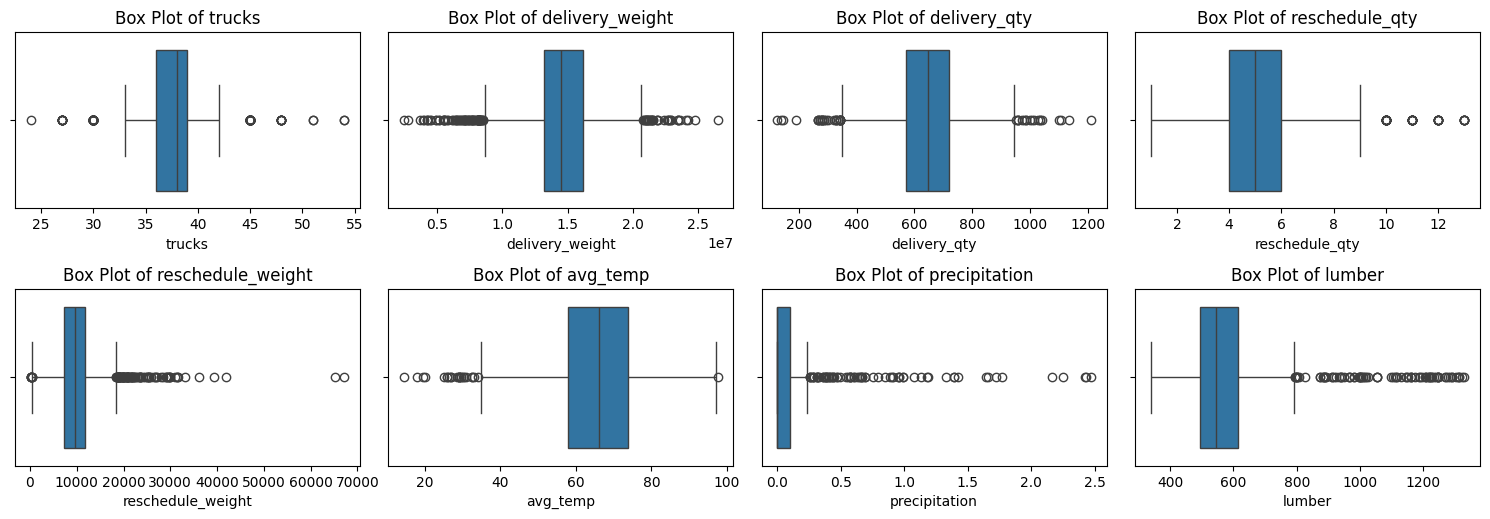

In [58]:
numerical_columns = final_df.drop('date', axis=1).columns

# Set up viz layout
plt.figure(figsize=(15, 10))

# For-loop to make box plots for numerical_columns
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x=final_df[column])
    plt.title(f'Box Plot of {column}')

# Tight layout and show
plt.tight_layout()
plt.show()

Observations:
- The number of actual trucks has always been within the range of expected trucks.
- `delivery_weight` and `delivery_qty` are both in the middle of their graphs, indicating their potentially direct correlation with each other.
- The common outliers within `precipitation` indicate that there wasn't much precipitation in Denton, TX from 1/3/22 to 3/17/25. This also corresponds with the low `reschedule_weight` and possibly `reschedule_qty` since reschedules could happen due to lots of rain or snow.
- Other: Avg. temperatures have been higher, and high lumber has not been common.



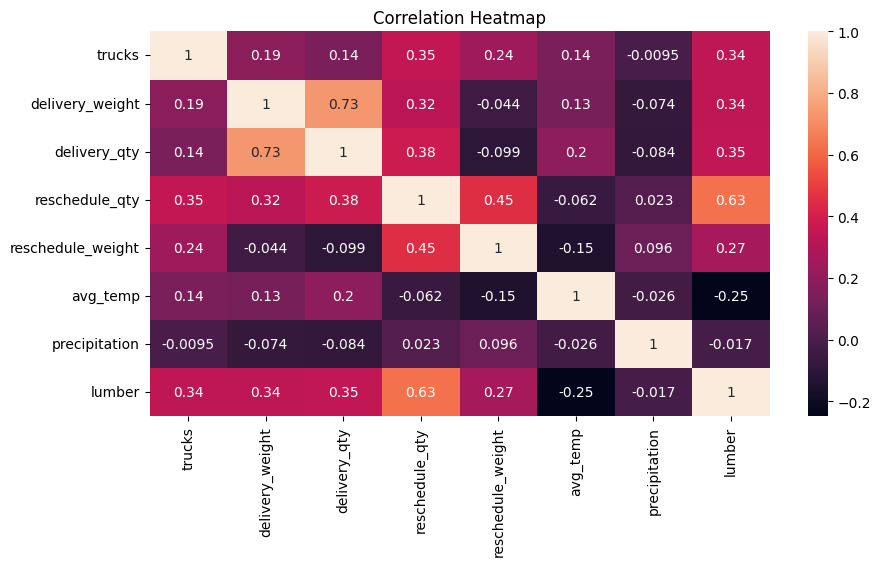

In [59]:
# Visualize correlations between numerical features (no date)
plt.figure(figsize=(10,5))
sns.heatmap(final_df.drop(columns='date').corr(), annot=True)
plt.title('Correlation Heatmap')
plt.show()

Observations:
- `delivery_weight` and `delivery_qty` are highly correlated with each other at 0.73. The same goes for `reschedule_qty` and `reschedule_weight` at 0.45.
- `precipitation`'s highest correlations are in `reschedule_qty` at 0.023 and `reschedule_weight` at 0.096. This may signify the importance of rescheduling deliveries due to too much rainfall.
- `lumber` has positive correlations, except for `avg_temp` at -0.25 and `precipitation` at -0.017. The most realistic connection is lumber increasing from more trucks and deliveries.

## Visualizations

In [60]:
viz_df = final_df.copy()

# Rename columns for visualizations
viz_df.rename(columns={
    'date': 'Date',
    'trucks': 'Trucks (qty)',
    'delivery_qty': 'Deliveries (qty)',
    'delivery_weight': 'Deliveries (lbs.)',
    'reschedule_qty': 'Reschedules (qty)',
    'reschedule_weight': 'Reschedules (lbs.)',
    'avg_temp': 'Temperature (°F)',
    'precipitation': 'Precipitation (in)',
    'lumber': 'Lumber ($)'
}, inplace=True)

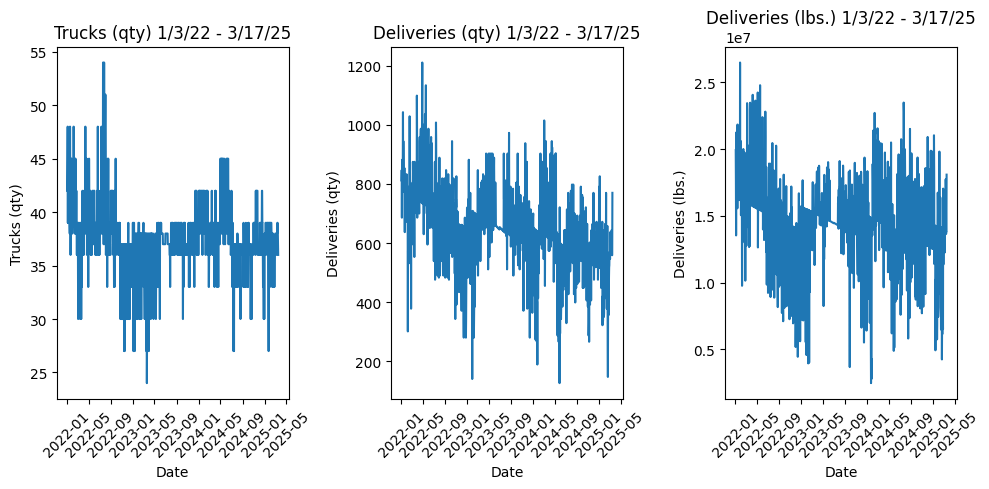

In [61]:
import matplotlib.dates as mdates

columns = ['Trucks (qty)', 'Deliveries (qty)', 'Deliveries (lbs.)']

# Three-viz layout
fig, axes = plt.subplots(1, 3, figsize=(10,5))


# Line plot for-loop
for i, column in enumerate(columns, 1):
    plt.subplot(1, 3, i)
    sns.lineplot(x='Date', y=column, data=viz_df)
    plt.title(f'{column} 1/3/22 - 3/17/25')
    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel(column)

# Tight layout and show
plt.tight_layout()
plt.show()

Observations:
- Since the highest trucks and deliveries in 2022, they dipped to their lowest by Sept. 2022.  
  - However, they have since increased and stabalized starting Jan. 2023.

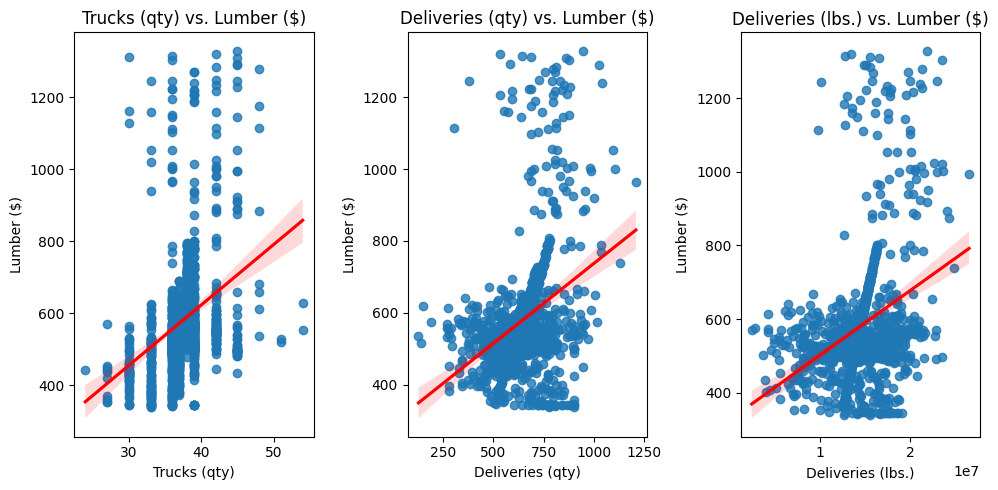

In [62]:
columns = ['Trucks (qty)', 'Deliveries (qty)', 'Deliveries (lbs.)']

# Three-viz layout
fig, axes = plt.subplots(1, 3, figsize=(10,5))

# Regression plot for-loop
for i, column in enumerate(columns, 1):
    plt.subplot(1, 3, i)
    sns.regplot(x=column, y='Lumber ($)', data=viz_df, ax=axes[i-1], line_kws={'color': 'red'})
    plt.title(f'{column} vs. Lumber ($)')
    plt.xlabel(column)
    plt.ylabel('Lumber ($)')

# Tight layout and show
plt.tight_layout()
plt.show()

Observations:
- More trucks and deliveries indicate a clear **increase in lumber's value.**  
  - When the trucks and deliveries were at their highest and lowest, the lumber reflects as such.

### Weather

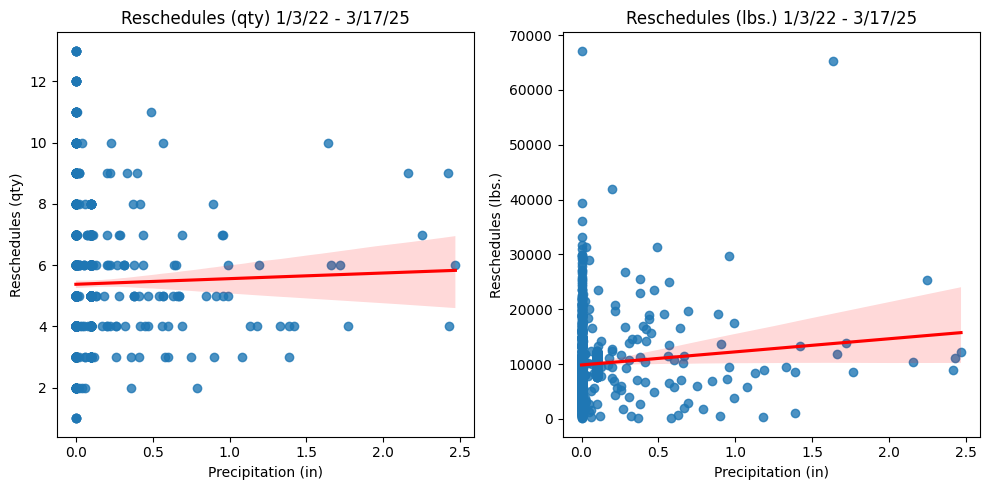

In [63]:
columns = ['Reschedules (qty)', 'Reschedules (lbs.)']

# Two-viz layout
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Regression plot for-loop
for i, column in enumerate(columns, 1):
    plt.subplot(1, 2, i)
    sns.regplot(x='Precipitation (in)', y=column, data=viz_df, ax=axes[i-1], line_kws={'color': 'red'})
    plt.title(f'{column} 1/3/22 - 3/17/25')
    plt.xlabel('Precipitation (in)')
    plt.ylabel(column)

# Tight layout and show
plt.tight_layout()
plt.show()

Observations:
- Deliveries may be **rescheduled** because of **high precipitation.**  
- Up to 2.5 inches of rain may result in over 20000 reschedules.  
    - Meanwhile, the _quantity_ may stay around 5 without much of a change.

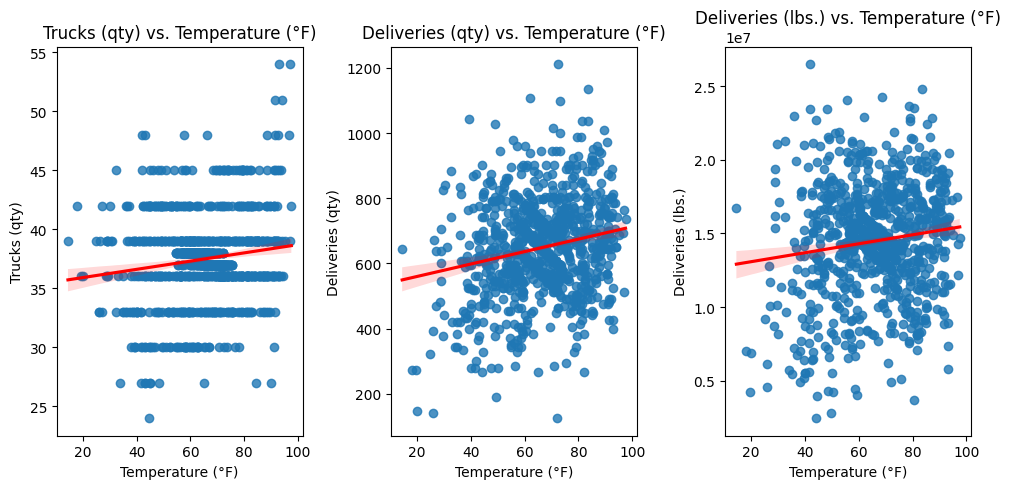

In [64]:
columns = ['Trucks (qty)', 'Deliveries (qty)', 'Deliveries (lbs.)']

# Three-viz layout
fig, axes = plt.subplots(1, 3, figsize=(10,5))

# Regression plot for-loop
for i, column in enumerate(columns, 1):
    plt.subplot(1, 3, i)
    sns.regplot(x='Temperature (°F)', y=column, data=viz_df, ax=axes[i-1], line_kws={'color': 'red'})
    plt.title(f'{column} vs. Temperature (°F)')
    plt.xlabel('Temperature (°F)')
    plt.ylabel(column)

# Tight layout and show
plt.tight_layout()
plt.show()

Observations:
- **Higher temperatures** result in **more trucks and deliveries.**  
- Temperatures up to 100°F are more likely to get trucks and deliveries than those at 20°F.  
  - This makes summer (June-Sept.) **the ideal construction season.**

## Conclusion & Next Steps

Trucks and deliveries have remained stable starting 2023 in terms of past weather and lumber data.

**Different weather conditions can't be helped, but we can work with them to maximize lumber's value in today's economy.**
* Maximize trucks and deliveries during the **summer**, where the temperatures are at theit highest.
  * Target more sunny days than cloudy/rainy ones to minimize the chance of precipitation.
* Expect a decrease in reschedules whenever precipitation is forecasted in the coming days.
  * Likewise, expect a decrease in overall performance during the winter with lower temperatures.
* When the eocnomy favors lumber, splurge in the trucks and deliveries to make more profit.